# Klasifikasi Gambar Herbal dengan Xception
Versi yang disederhanakan dan dilengkapi dengan mekanisme evaluasi split data dan early stopping otomatis.

In [1]:
# Import libraries
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
# Verify torchvision models availability
try:
    test_model = models.resnet50(pretrained=False)
    print("ResNet50 is available in torchvision.models")
    del test_model
except AttributeError:
    print("Warning: ResNet50 not found in torchvision.models")
    print("Available models:", [attr for attr in dir(models) if not attr.startswith('_')])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50 is available in torchvision.models


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# Set parameters
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 20
base_path = '/content/drive/MyDrive/DATASET2'

In [6]:
# Custom Dataset class
class HerbalDataset(Dataset):
    def __init__(self, root_dir, transform=None, classes=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        if classes is None:
            self.classes = sorted(os.listdir(root_dir))
        else:
            self.classes = classes

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

        # Load all images and labels
        for class_idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# Alternative ResNet50 implementation
def create_resnet50_alternative(num_classes, pretrained=True):
    """Alternative way to create ResNet50 if torchvision.models fails"""
    try:
        from torchvision.models import resnet50
        model = resnet50(pretrained=pretrained)
        return model
    except ImportError:
        try:
            import torchvision.models as tvmodels
            model = tvmodels.resnet50(pretrained=pretrained)
            return model
        except:
            model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=pretrained)
            return model

In [8]:
# Custom ResNet50 Model
class ResNet50Classifier(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(ResNet50Classifier, self).__init__()

        try:
            self.backbone = models.resnet50(pretrained=pretrained)
            print("✅ ResNet50 loaded successfully using torchvision.models")
        except AttributeError as e:
            print(f"❌ Primary method failed: {e}")
            try:
                self.backbone = create_resnet50_alternative(num_classes, pretrained)
                print("✅ ResNet50 loaded using alternative method")
            except Exception as e2:
                print(f"❌ Alternative method also failed: {e2}")
                raise Exception("Cannot load ResNet50. Please check PyTorch/torchvision installation.")

        # Remove the final classification layer
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Add custom classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        output = self.classifier(features)
        return output

In [9]:
# Data transforms
def get_transforms(is_training=True):
    return transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

In [10]:
# Display sample images function
def display_samples(dataloader, class_names, num_samples=8, samples_per_class=2):
    """Display sample images from dataloader"""
    displayed_counts = {name: 0 for name in class_names}
    total_displayed = 0

    # Inverse normalize for display
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )

    for batch_images, batch_labels in dataloader:
        for i in range(len(batch_images)):
            if total_displayed >= num_samples:
                return

            label_idx = batch_labels[i].item()
            class_name = class_names[label_idx]

            if displayed_counts[class_name] < samples_per_class:
                # Denormalize and convert to displayable format
                img = inv_normalize(batch_images[i])
                img = torch.clamp(img, 0, 1)
                img_np = img.permute(1, 2, 0).numpy()
                img_bgr = cv2.cvtColor((img_np * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)

                print(f"Label: {class_name}")
                from google.colab.patches import cv2_imshow
                cv2_imshow(img_bgr)

                displayed_counts[class_name] += 1
                total_displayed += 1

In [11]:
# Three-way data split function
def create_three_way_split(dataset, train_ratio, val_ratio, test_ratio):
    """
    Split dataset into train, validation, and test sets
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1.0"

    dataset_size = len(dataset)

    # Calculate sizes
    train_size = int(dataset_size * train_ratio)
    val_size = int(dataset_size * val_ratio)
    test_size = dataset_size - train_size - val_size  # Remaining samples go to test

    print(f"Dataset split:")
    print(f"  Total samples: {dataset_size}")
    print(f"  Train: {train_size} ({train_size/dataset_size:.1%})")
    print(f"  Validation: {val_size} ({val_size/dataset_size:.1%})")
    print(f"  Test: {test_size} ({test_size/dataset_size:.1%})")

    # Random split
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(42)  # For reproducibility
    )

    return train_dataset, val_dataset, test_dataset

In [12]:
# Training function with three-way split
def train_with_three_way_split(train_ratio, val_ratio, test_ratio):
    split_name = f"{int(train_ratio*100)}:{int(val_ratio*100)}:{int(test_ratio*100)}"
    print(f"\n{'='*60}")
    print(f"Training dengan rasio Train:Val:Test = {split_name}")
    print(f"{'='*60}")

    # Create full dataset
    full_dataset = HerbalDataset(
        root_dir=os.path.join(base_path, 'train'),
        transform=get_transforms(is_training=True)
    )

    # Three-way split
    train_dataset, val_dataset, test_dataset = create_three_way_split(
        full_dataset, train_ratio, val_ratio, test_ratio
    )

    # Create separate datasets with appropriate transforms
    train_transform_dataset = HerbalDataset(
        root_dir=os.path.join(base_path, 'train'),
        transform=get_transforms(is_training=True),
        classes=full_dataset.classes
    )

    val_transform_dataset = HerbalDataset(
        root_dir=os.path.join(base_path, 'train'),
        transform=get_transforms(is_training=False),
        classes=full_dataset.classes
    )

    test_transform_dataset = HerbalDataset(
        root_dir=os.path.join(base_path, 'train'),
        transform=get_transforms(is_training=False),
        classes=full_dataset.classes
    )

    # Create subset datasets using the split indices
    train_subset = torch.utils.data.Subset(train_transform_dataset, train_dataset.indices)
    val_subset = torch.utils.data.Subset(val_transform_dataset, val_dataset.indices)
    test_subset = torch.utils.data.Subset(test_transform_dataset, test_dataset.indices)

    # Create data loaders
    train_loader = DataLoader(
        train_subset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2
    )

    val_loader = DataLoader(
        val_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    test_loader = DataLoader(
        test_subset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=2
    )

    print(f"\nData distribution:")
    print(f"  Training batches: {len(train_loader)} (samples: {len(train_subset)})")
    print(f"  Validation batches: {len(val_loader)} (samples: {len(val_subset)})")
    print(f"  Test batches: {len(test_loader)} (samples: {len(test_subset)})")
    print(f"  Batch size: {BATCH_SIZE}")

    # Display sample images
    print(f"\nSample images from training set:")
    display_samples(train_loader, full_dataset.classes, num_samples=8, samples_per_class=2)

    # Create model
    num_classes = len(full_dataset.classes)
    model = ResNet50Classifier(num_classes=num_classes).to(device)

    # Compute class weights from training data only
    train_labels = [full_dataset.labels[i] for i in train_dataset.indices]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

    # No early stopping - training will run for full epochs

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }

    # Training loop
    best_val_acc = 0.0
    start_time = time.time()

    for epoch in range(EPOCHS):
        epoch_start = time.time()

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += targets.size(0)
            train_correct += predicted.eq(targets).sum().item()

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += targets.size(0)
                val_correct += predicted.eq(targets).sum().item()

        # Calculate metrics
        train_loss_avg = train_loss / len(train_loader)
        val_loss_avg = val_loss / len(val_loader)
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total

        # Store history
        history['train_loss'].append(train_loss_avg)
        history['val_loss'].append(val_loss_avg)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        epoch_time = time.time() - epoch_start
        print(f'Epoch {epoch+1:2d}/{EPOCHS}: '
              f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.4f} | '
              f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.4f} | '
              f'Time: {epoch_time:.1f}s')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{split_name.replace(':', '_')}.pt")

        # Learning rate scheduler
        scheduler.step(val_loss_avg)

        # No early stopping - continue training for all epochs

    training_time = time.time() - start_time
    print(f"\n⌛ Total training time: {training_time:.1f}s")
    print(f"🏆 Best validation accuracy: {best_val_acc:.4f}")

    # Final evaluation on test set
    print(f"\n{'='*40}")
    print("FINAL EVALUATION ON TEST SET")
    print(f"{'='*40}")

    # Load best model
    model.load_state_dict(torch.load(f"best_model_{split_name.replace(':', '_')}.pt"))
    model.eval()

    # Test evaluation
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    all_test_preds = []
    all_test_targets = []

    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()

            all_test_preds.extend(predicted.cpu().numpy())
            all_test_targets.extend(targets.cpu().numpy())

    test_loss_avg = test_loss / len(test_loader)
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss_avg:.4f}")
    print(f"Test Accuracy: {test_acc:.4f} ({test_acc:.2%})")

    # Classification report on test set
    class_names = full_dataset.classes
    print(f"\nTest Set Classification Report:")
    print(classification_report(all_test_targets, all_test_preds, target_names=class_names))

    # Confusion matrix for test set
    cm = confusion_matrix(all_test_targets, all_test_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Test Set Confusion Matrix - Split {split_name}')
    plt.tight_layout()
    plt.savefig(f'test_confusion_matrix_{split_name.replace(":", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Save final model
    torch.save(model.state_dict(), f"final_model_{split_name.replace(':', '_')}.pt")

    return history, model, full_dataset.classes, test_acc

In [13]:
# Plot performance function
def plot_training_performance(history, split_label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot Loss
    ax1.plot(history['train_loss'], label='Train Loss', linewidth=2)
    ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title(f'Training vs Validation Loss\n({split_label})', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot Accuracy
    ax2.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
    ax2.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    ax2.set_title(f'Training vs Validation Accuracy\n({split_label})', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'training_curves_{split_label.replace(":", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

In [22]:
from torchvision import datasets
import torchvision.transforms as transforms # Make sure transforms is imported

# Define the path to your dataset directory
# Replace 'path_ke_dataset' with the actual path to your image dataset
dataset_path = '/content/drive/MyDrive/DATASET2/train' # Assuming this is the correct path

# Get the appropriate transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


# Create the ImageFolder dataset
dataset = datasets.ImageFolder(dataset_path, transform=transform)

# Print the class to index mapping
print(dataset.class_to_idx)

{'Jahe': 0, 'Kencur': 1, 'Kunyit': 2, 'Temulawak': 3}


🚀 Starting training with three different data split configurations...
Split configurations: Train:Validation:Test
  - 60:20:20
  - 70:15:15
  - 80:10:10

🔄 Starting configuration 1/3: 60:20:20

Training dengan rasio Train:Val:Test = 60:20:20
Dataset split:
  Total samples: 1200
  Train: 720 (60.0%)
  Validation: 240 (20.0%)
  Test: 240 (20.0%)

Data distribution:
  Training batches: 23 (samples: 720)
  Validation batches: 8 (samples: 240)
  Test batches: 8 (samples: 240)
  Batch size: 32

Sample images from training set:
Label: Kunyit


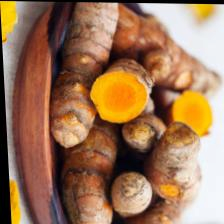

Label: Jahe


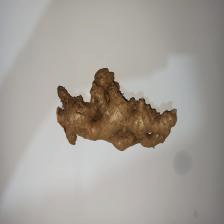

Label: Kencur


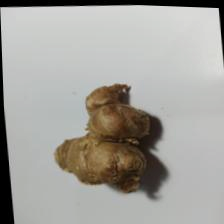

Label: Jahe


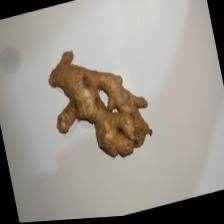

Label: Temulawak


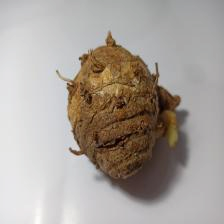

Label: Kunyit


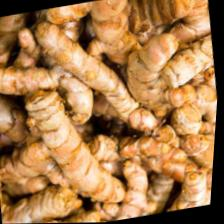

Label: Kencur


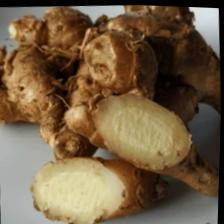

Label: Temulawak


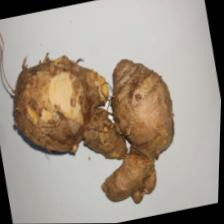

❌ Primary method failed: 'list' object has no attribute 'resnet50'


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 106MB/s]


✅ ResNet50 loaded using alternative method
Epoch  1/20: Train Loss: 0.7573, Train Acc: 0.7750 | Val Loss: 0.1844, Val Acc: 0.9458 | Time: 118.5s
Epoch  2/20: Train Loss: 0.1540, Train Acc: 0.9653 | Val Loss: 0.0637, Val Acc: 0.9875 | Time: 8.8s
Epoch  3/20: Train Loss: 0.0525, Train Acc: 0.9875 | Val Loss: 0.0940, Val Acc: 0.9667 | Time: 8.8s
Epoch  4/20: Train Loss: 0.0477, Train Acc: 0.9847 | Val Loss: 0.0386, Val Acc: 0.9958 | Time: 8.5s
Epoch  5/20: Train Loss: 0.0287, Train Acc: 0.9931 | Val Loss: 0.0315, Val Acc: 0.9833 | Time: 9.1s
Epoch  6/20: Train Loss: 0.0191, Train Acc: 0.9972 | Val Loss: 0.0842, Val Acc: 0.9667 | Time: 8.9s
Epoch  7/20: Train Loss: 0.0291, Train Acc: 0.9917 | Val Loss: 0.1132, Val Acc: 0.9583 | Time: 9.1s
Epoch  8/20: Train Loss: 0.0423, Train Acc: 0.9875 | Val Loss: 0.1586, Val Acc: 0.9542 | Time: 9.4s
Epoch  9/20: Train Loss: 0.0351, Train Acc: 0.9889 | Val Loss: 0.1098, Val Acc: 0.9667 | Time: 9.2s
Epoch 10/20: Train Loss: 0.0154, Train Acc: 0.9972 | Va

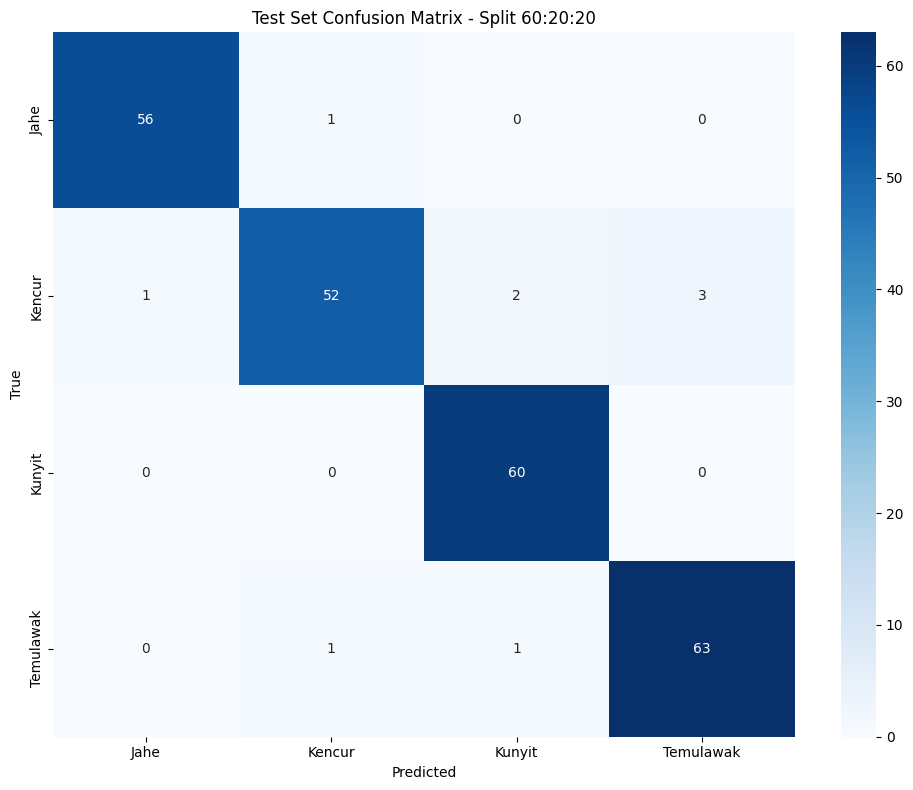

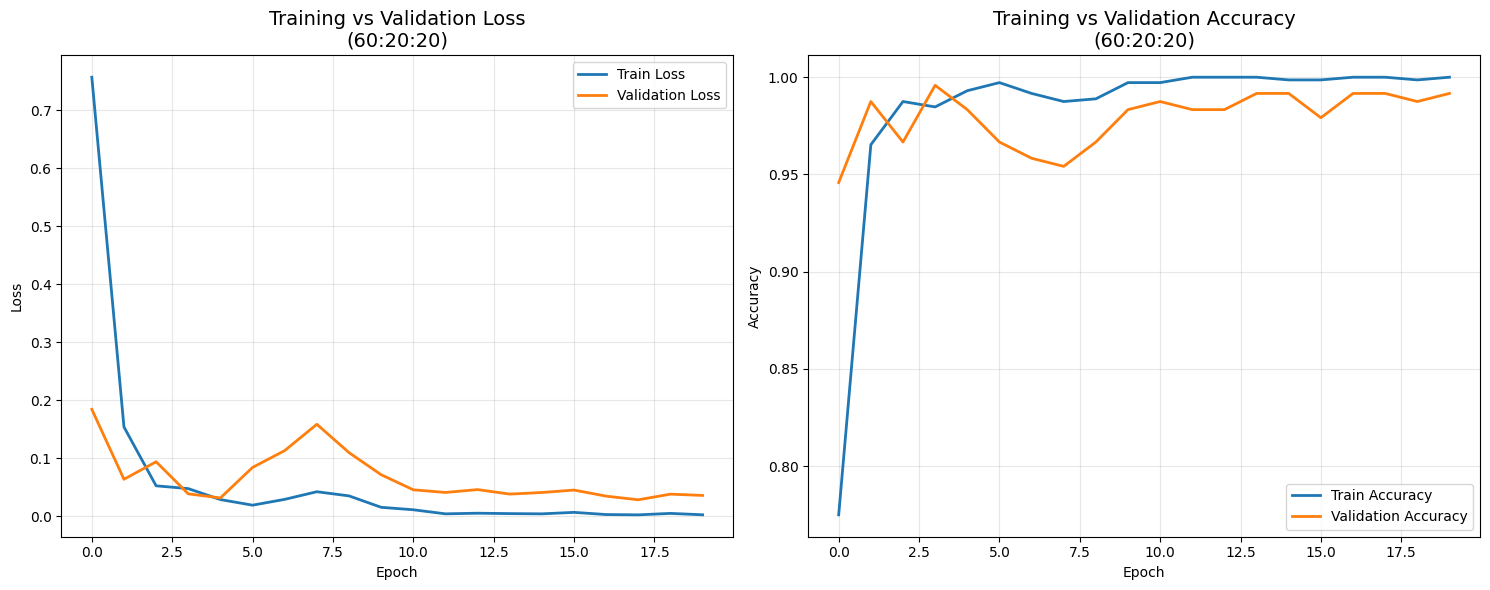


🔄 Starting configuration 2/3: 70:15:15

Training dengan rasio Train:Val:Test = 70:15:15
Dataset split:
  Total samples: 1200
  Train: 840 (70.0%)
  Validation: 180 (15.0%)
  Test: 180 (15.0%)

Data distribution:
  Training batches: 27 (samples: 840)
  Validation batches: 6 (samples: 180)
  Test batches: 6 (samples: 180)
  Batch size: 32

Sample images from training set:
Label: Kunyit


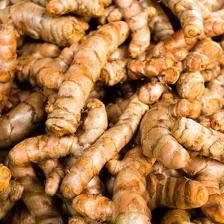

Label: Kencur


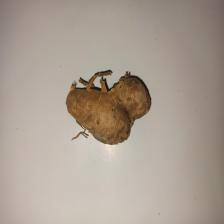

Label: Temulawak


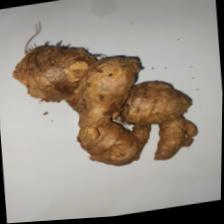

Label: Kunyit


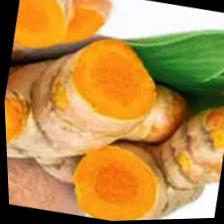

Label: Kencur


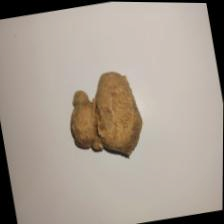

Label: Temulawak


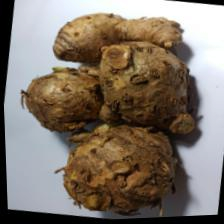

Label: Jahe


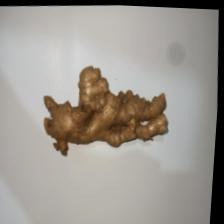

Label: Jahe


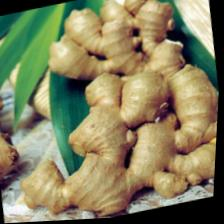

❌ Primary method failed: 'list' object has no attribute 'resnet50'


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet50 loaded using alternative method
Epoch  1/20: Train Loss: 0.6692, Train Acc: 0.7821 | Val Loss: 0.2204, Val Acc: 0.9167 | Time: 10.4s
Epoch  2/20: Train Loss: 0.1193, Train Acc: 0.9750 | Val Loss: 0.1844, Val Acc: 0.9444 | Time: 10.3s
Epoch  3/20: Train Loss: 0.0821, Train Acc: 0.9750 | Val Loss: 0.1849, Val Acc: 0.9333 | Time: 10.6s
Epoch  4/20: Train Loss: 0.1079, Train Acc: 0.9810 | Val Loss: 0.0861, Val Acc: 0.9667 | Time: 10.8s
Epoch  5/20: Train Loss: 0.1124, Train Acc: 0.9845 | Val Loss: 0.0930, Val Acc: 0.9556 | Time: 10.9s
Epoch  6/20: Train Loss: 0.0931, Train Acc: 0.9726 | Val Loss: 0.1019, Val Acc: 0.9500 | Time: 10.3s
Epoch  7/20: Train Loss: 0.0964, Train Acc: 0.9881 | Val Loss: 0.0810, Val Acc: 0.9889 | Time: 10.0s
Epoch  8/20: Train Loss: 0.0534, Train Acc: 0.9857 | Val Loss: 0.0491, Val Acc: 0.9889 | Time: 9.9s
Epoch  9/20: Train Loss: 0.0379, Train Acc: 0.9929 | Val Loss: 0.0659, Val Acc: 0.9833 | Time: 10.3s
Epoch 10/20: Train Loss: 0.0620, Train Acc: 0.983

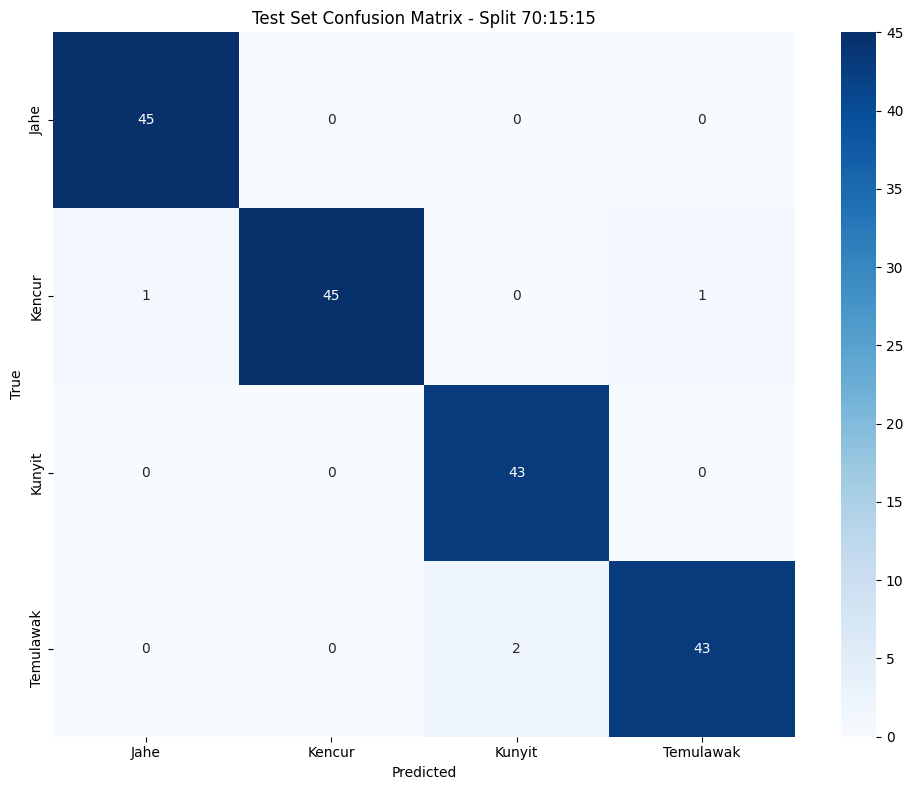

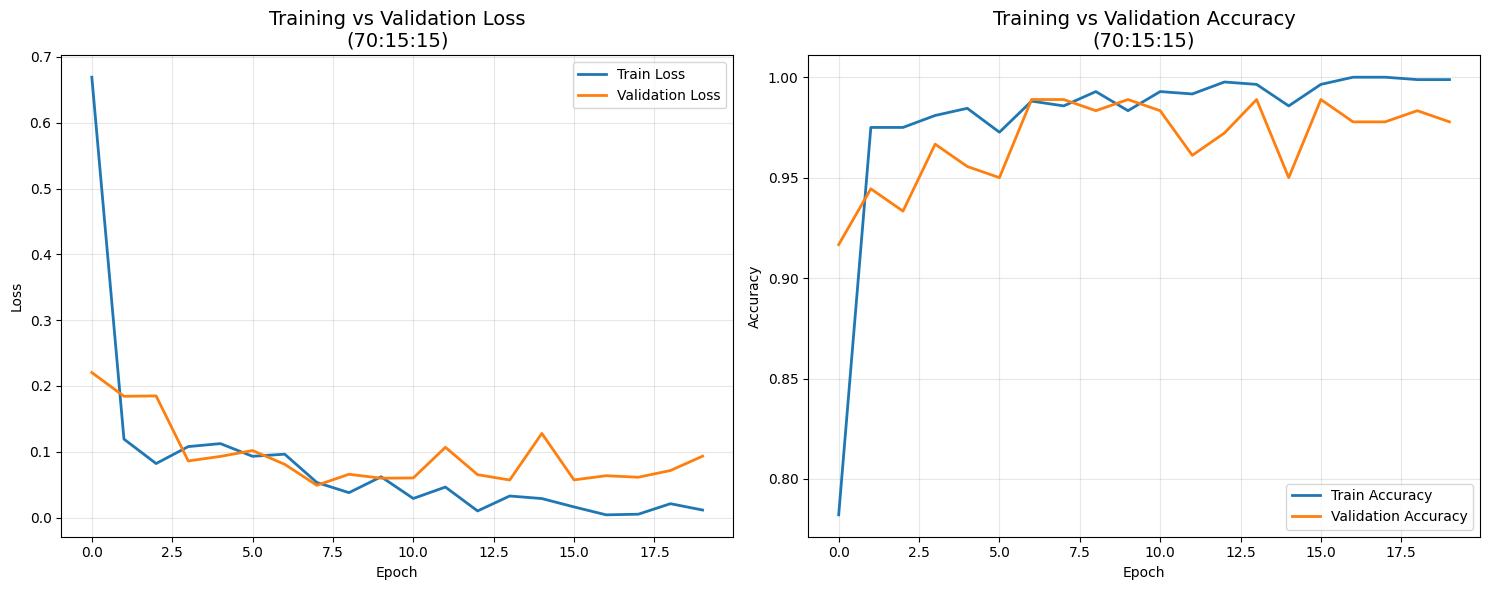


🔄 Starting configuration 3/3: 80:10:10

Training dengan rasio Train:Val:Test = 80:10:10
Dataset split:
  Total samples: 1200
  Train: 960 (80.0%)
  Validation: 120 (10.0%)
  Test: 120 (10.0%)

Data distribution:
  Training batches: 30 (samples: 960)
  Validation batches: 4 (samples: 120)
  Test batches: 4 (samples: 120)
  Batch size: 32

Sample images from training set:
Label: Kunyit


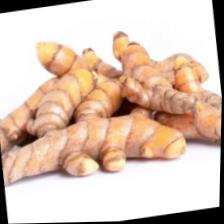

Label: Kunyit


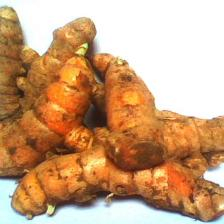

Label: Kencur


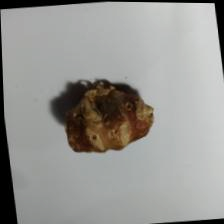

Label: Kencur


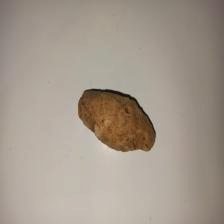

Label: Temulawak


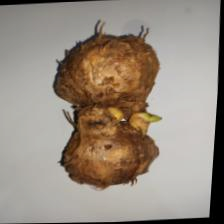

Label: Temulawak


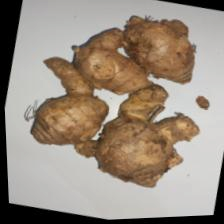

Label: Jahe


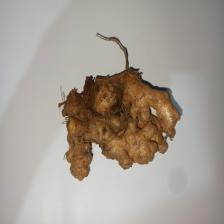

Label: Jahe


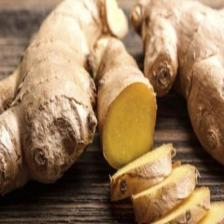

❌ Primary method failed: 'list' object has no attribute 'resnet50'


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet50 loaded using alternative method
Epoch  1/20: Train Loss: 0.6463, Train Acc: 0.7885 | Val Loss: 0.1722, Val Acc: 0.9500 | Time: 11.1s
Epoch  2/20: Train Loss: 0.0884, Train Acc: 0.9760 | Val Loss: 0.0673, Val Acc: 0.9833 | Time: 11.2s
Epoch  3/20: Train Loss: 0.0604, Train Acc: 0.9844 | Val Loss: 0.0312, Val Acc: 1.0000 | Time: 11.6s
Epoch  4/20: Train Loss: 0.0238, Train Acc: 0.9948 | Val Loss: 0.0512, Val Acc: 0.9917 | Time: 11.5s
Epoch  5/20: Train Loss: 0.0147, Train Acc: 0.9979 | Val Loss: 0.0616, Val Acc: 0.9917 | Time: 11.3s
Epoch  6/20: Train Loss: 0.0222, Train Acc: 0.9927 | Val Loss: 0.2217, Val Acc: 0.9333 | Time: 11.3s
Epoch  7/20: Train Loss: 0.0171, Train Acc: 0.9969 | Val Loss: 0.1024, Val Acc: 0.9583 | Time: 11.4s
Epoch  8/20: Train Loss: 0.0180, Train Acc: 0.9938 | Val Loss: 0.1025, Val Acc: 0.9500 | Time: 11.2s
Epoch  9/20: Train Loss: 0.0074, Train Acc: 0.9990 | Val Loss: 0.0833, Val Acc: 0.9750 | Time: 11.3s
Epoch 10/20: Train Loss: 0.0076, Train Acc: 0.99

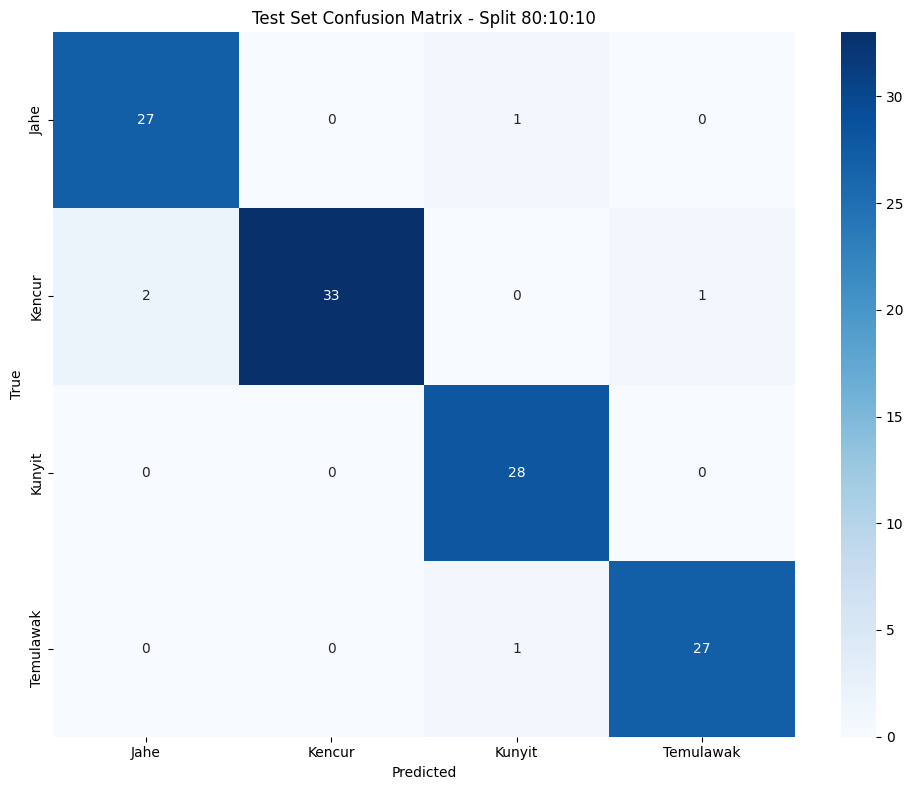

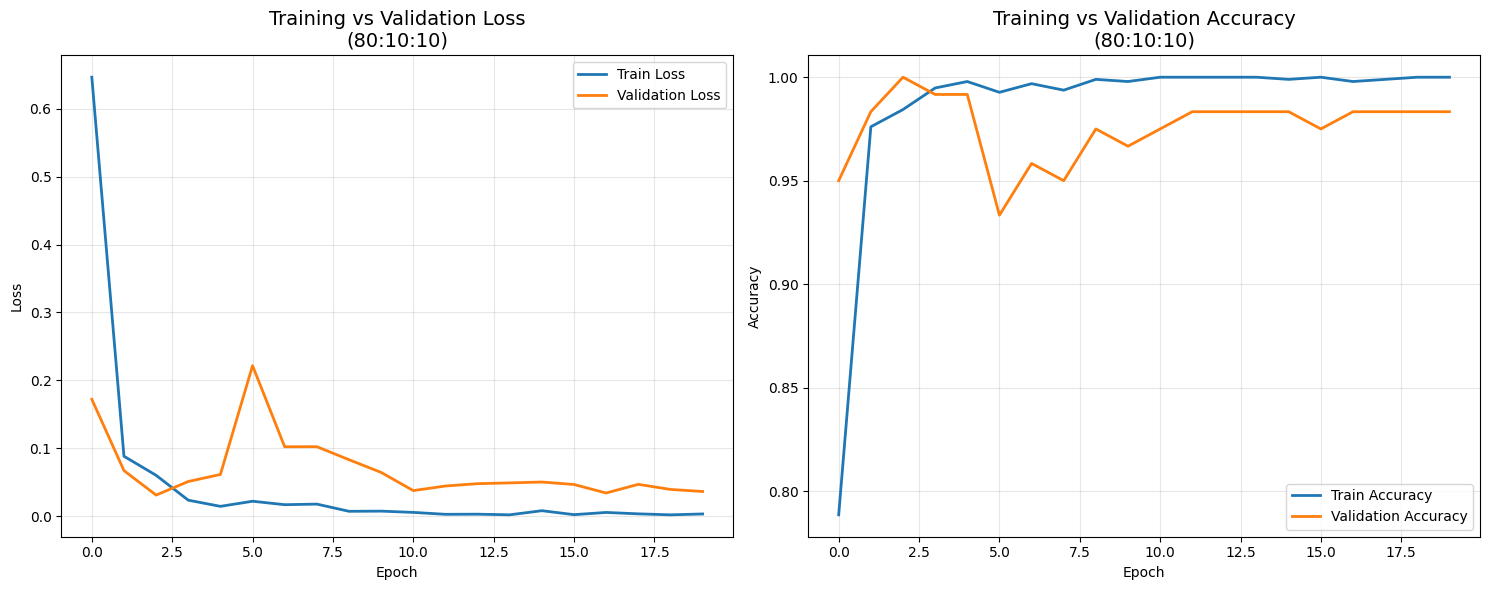

In [14]:
# Run training with different three-way splits
splits_config = [
    (0.6, 0.2, 0.2),  # 60:20:20
    (0.7, 0.15, 0.15), # 70:15:15
    (0.8, 0.1, 0.1)    # 80:10:10
]

split_labels = ['60:20:20', '70:15:15', '80:10:10']
histories = []
models = []
test_accuracies = []
class_names = None

print("🚀 Starting training with three different data split configurations...")
print("Split configurations: Train:Validation:Test")
for label in split_labels:
    print(f"  - {label}")

for i, (train_ratio, val_ratio, test_ratio) in enumerate(splits_config):
    print(f"\n🔄 Starting configuration {i+1}/3: {split_labels[i]}")

    history, model, classes, test_acc = train_with_three_way_split(
        train_ratio, val_ratio, test_ratio
    )

    histories.append(history)
    models.append(model)
    test_accuracies.append(test_acc)

    if class_names is None:
        class_names = classes

    # Plot performance
    plot_training_performance(history, split_labels[i])

In [15]:
# Summary comparison
print(f"\n{'='*60}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*60}")
print("Split Configuration  | Test Accuracy")
print("-" * 35)
for i, (label, test_acc) in enumerate(zip(split_labels, test_accuracies)):
    print(f"{label:18s} | {test_acc:.4f} ({test_acc:.2%})")


FINAL RESULTS SUMMARY
Split Configuration  | Test Accuracy
-----------------------------------
60:20:20           | 0.9625 (96.25%)
70:15:15           | 0.9778 (97.78%)
80:10:10           | 0.9583 (95.83%)


(0.0, 1.0)

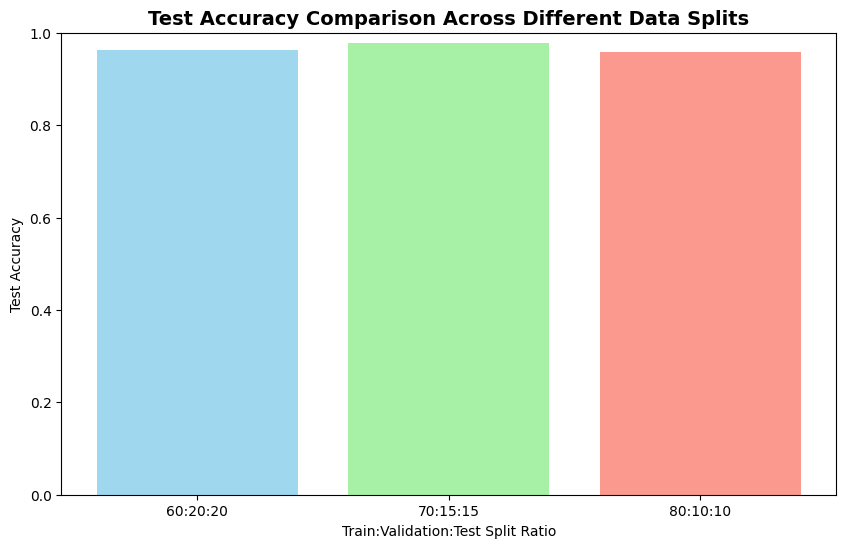

In [16]:
# Plot comparison of test accuracies
plt.figure(figsize=(10, 6))
bars = plt.bar(split_labels, test_accuracies, color=['skyblue', 'lightgreen', 'salmon'], alpha=0.8)
plt.title('Test Accuracy Comparison Across Different Data Splits', fontsize=14, fontweight='bold')
plt.xlabel('Train:Validation:Test Split Ratio')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1.0)

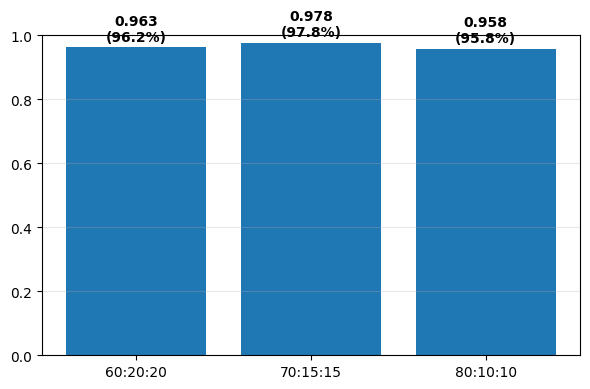


✅ All training configurations completed!
📊 Best performing split: 70:15:15 with 97.78% test accuracy


In [17]:
# Add value labels on bars
plt.figure(figsize=(6, 4))  # Ukuran lebar 6 inch, tinggi 4 inch
bars = plt.bar(range(len(test_accuracies)), test_accuracies)

# Tambahkan label nilai akurasi pada tiap bar
for bar, acc in zip(bars, test_accuracies):
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height() + 0.01,
             f'{acc:.3f}\n({acc:.1%})',
             ha='center', va='bottom', fontweight='bold')

plt.xticks(range(len(split_labels)), split_labels)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('test_accuracy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


print("\n✅ All training configurations completed!")
print(f"📊 Best performing split: {split_labels[np.argmax(test_accuracies)]} with {max(test_accuracies):.2%} test accuracy")

In [18]:
# Inference function (updated for the new model structure)
def predict_image(model_path, image_path, class_names, threshold=0.7):
    """Predict single image using trained ResNet50 model"""
    # Load model
    model = ResNet50Classifier(num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Load and preprocess image
    transform = get_transforms(is_training=False)
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

        confidence = confidence.item()
        predicted_class = class_names[predicted.item()]

    # Display result
    if confidence >= threshold:
        result_text = f"Prediksi: {predicted_class} (Confidence: {confidence:.3f})"
    else:
        result_text = f"Prediksi: Tidak dikenali (Confidence: {confidence:.3f})"

    print(result_text)

    # Display image
    img_display = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    from google.colab.patches import cv2_imshow
    cv2_imshow(img_display)

    return predicted_class, confidence

Saving temulawak-4-_jpg.rf.ebbca2e35566f050e8c65bd32e914d79.jpg to temulawak-4-_jpg.rf.ebbca2e35566f050e8c65bd32e914d79.jpg

Processing image: temulawak-4-_jpg.rf.ebbca2e35566f050e8c65bd32e914d79.jpg
❌ Primary method failed: 'list' object has no attribute 'resnet50'
✅ ResNet50 loaded using alternative method
Prediksi: Temulawak (Confidence: 0.947)


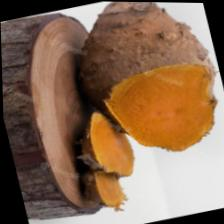

In [21]:
from google.colab import files
import cv2
import numpy as np
from PIL import Image
from google.colab.patches import cv2_imshow
import torch # Import torch

# Upload gambar
uploaded = files.upload()

# Get class names from the training process (assuming the last training run's class_names are desired)
# Replace this with the actual class names used during training if they are different
# For example, if class_names was stored in a variable after the training loop:
# class_names_for_inference = class_names
# Or manually define them if they are fixed:
class_names_for_inference = ['Jahe', 'Kencur', 'Kunyit', 'Temulawak'] # Assuming these are the correct class names

# Define the path to the trained model
model_path = "final_model_70_15_15.pt"

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Ukuran input model (used within get_transforms, so not strictly needed here but kept for clarity)
input_size = (224, 224)
threshold = 0.7  # ambang kepercayaan

for file_name in uploaded.keys():
    print(f"\nProcessing image: {file_name}")
    # Use the predict_image function to handle loading, prediction, and display
    predicted_class, confidence = predict_image(
        model_path,
        file_name, # Use the uploaded file_name as the image_path
        class_names_for_inference,
        threshold
    )